In [1]:
using LinearAlgebra, Plots, FastGaussQuadrature
include("..\\Code_jail\\Misc.jl")
include("..\\Code_jail\\myquad.jl")

Hermite_quad (generic function with 1 method)

# Morituri te salutant

In [2]:
function OrderRoots(x)
    angles = angle.(x)
    sorted_indices = sortperm(angles)
    return x[sorted_indices]
end

OrderRoots (generic function with 1 method)

The Function below in a readable format are, with $w\in\mathbb{C}^m$
$$ϕ = i(k-\frac{1}{x}\sum_{j=1}^mw_jk^{j+1}t^{\frac{m-j}{m+1}})$$
and 
$$P(w,x,t,k) = \exp(i(kx-\sum_{j=1}^mw_jk^{j+1}t^{\frac{m-j}{m+1}})).$$
In the end we would like to compute 
$$∫ \frac{P(w,\text{sgn}(Re(x))xt^{-1/(m+1)},t,k)}{(ik)^n}\mathrm{d}k =∫ \frac{1}{(ik)^n} \exp(it^{-1/(m+1)}(kRe(x)x-t\sum_{j=1}^mw_jk^{j+1}t^{-\frac{j}{m+1}})).$$

In [3]:
ω(w) = (z) -> sum([w[i] .* z.^(i + 1) for i in 1:length(w)])
Dω(w) = (z) -> sum([(i + 1) .* w[i] .* z.^(i) for i in 1:length(w)])
DDω(w) = (z) -> sum([(i + 1) * i .* w[i] .* z.^(i-1) for i in 1:length(w)])

Φ(w, x, t, k) = begin
    ω_kt = ω(w)(k .* t.^(-1 / (length(w) + 1)))
    return 1im*k .- 1im .* ω_kt .* t ./ x 
end

DΦ(w, x, t, k) = begin
    Dω_kt = Dω(w)(k .* t.^(-1 / (length(w) + 1))) .* t.^(-1 / (length(w) + 1))
    return 1im .- 1im .* Dω_kt .* t ./ x 
end

DDΦ(w, x, t, k) = begin
    DDω_kt = DDω(w)(k .* t.^(-1 / (length(w) + 1))) .* t.^(-2 / (length(w) + 1))
    return - 1im .* DDω_kt .* t ./ x 
end

P(w, x, t, k) = begin
    result = exp(x * Φ(w, x, t, k))
    if result ≈ 0.0
        return 0.0
    else
        return result
    end
end

P (generic function with 1 method)

In [4]:
function kk0(w, x, t)
    m = length(w);
    a = ones(m) .* 1im
    a[1] = x/(-(m+1)*w[m])
    for i1 = 1:(m-1)
        a[i1+1] = (i1+1)*w[i1]*t^((m-i1)/(m+1))/ ((m+1)*w[m] )
    end
    A = zeros(m,m) * 1im;
    for i1=1:m-1
        A[i1+1,i1] = 1.0;
    end
    A[:,m] = -1. .* a
    E = A |> eigen
    result = E.values |> filter(k -> imag(k) >= -1e-15)
    return OrderRoots(result)
end

k0 (generic function with 1 method)

In [5]:
function ArgD(w, x, t)
    arg = angle.(DDΦ(w, x, t, kk0(w, x, t)))
    return [arg]
end

ArgD (generic function with 1 method)

In [6]:
function mod_offset(x, m, offset)
    return offset .+ mod.(x .- offset, m)
end

mod_offset (generic function with 1 method)

In [7]:
function Dirs(w, x, t)
    argd = ArgD(w, x, t)
    return mod_offset(-argd[1] ./ 2 .+ π / 2, π, -π / 2)
end

Dirs (generic function with 1 method)

In [8]:
function ConnectPts(R, w)
    if sign(w[end]) < 0
        return [exp(1im * (4 * m + 1) / (2 * (length(w) + 1)) * π) * R for m in 0:length(w)]
    else
        return [exp(1im * (4 * m - 1) / (2 * (length(w) + 1)) * π) * R for m in 0:length(w)]
    end
end

ConnectPts (generic function with 1 method)

In [9]:
function SomeConnectPts(R, w)
    if sign(w[end]) < 0
        return [exp(1im * (4 * m + 1) / (2 * (length(w) + 1)) * π) * R for m in 0:floor(length(w)/2.)]
    else
        return [exp(1im * (4 * m - 1) / (2 * (length(w) + 1)) * π) * R for m in 0:floor(length(w)/2.) + 1]
    end
end

SomeConnectPts (generic function with 1 method)

In [10]:

function Min2(X, Y)
    out = []
    for x in X
        temp = abs.(Y .- x)
        p1 = argmin(temp)
        temp[p1] = Inf
        p2 = argmin(temp)
        push!(out, (Y[p1], Y[p2]))
    end
    return out
end

Min2 (generic function with 1 method)

In [11]:
function GlobalR(w, x, t)
    return (30 + abs(x)^2 + 1000 / length(w))^(1 / (length(w) + 1))
end

GlobalR (generic function with 1 method)

In [12]:
function Rads(w, xx, tt)
    K0 = kk0(w, xx, tt)
    close = Min2(K0, ConnectPts(GlobalR(w, xx, tt), w))
    args = Dirs(w, xx, tt) 
    maxrads = []
    if length(w) > 1
        for i in 1:length(close)
            θ = angle.(close[i][1])
            ϕ = θ - args[i]
            γ = K0[i] * exp(-1im * args[i])
            s = imag(γ) / imag(exp(1im * ϕ))
            r1 = s * exp(1im * ϕ) - γ
            θ = angle.(close[i][2])
            ϕ = θ - args[i]
            γ = K0[i] * exp(-1im * args[i])
            s = imag(γ) / imag(exp(1im * ϕ))
            r2 = s * exp(1im * ϕ) - γ
            push!(maxrads, minimum(abs.([r1, r2])))
        end
    else
        maxrads = [Inf]
    end
    scalerads = [10 / sqrt(abs(DDΦ(w, xx, tt, k)) * abs(xx / 2)) for k in K0]
    
    return K0, args, close, [minimum(r) for r in zip(maxrads, scalerads)]
end

Rads (generic function with 1 method)

In [13]:
function SDPaths(w, xx, tt)
    K0, args, close, rads = Rads(w, xx, tt)
    paths = [K0[i] .+ [rads[i] * exp(1im * (args[i] + π)) 0; 0 rads[i] * exp(1im * args[i])] for i in 1:length(K0)]
    return K0, close, paths
end

SDPaths (generic function with 1 method)

In [14]:
function sortreal(x)
    return sort(x, by=real)
end

sortreal (generic function with 1 method)

In [15]:
function SmallXPath(w, x, t)
    p1 = sortreal(SomeConnectPts(0.5, w))
    p2 = sortreal(SomeConnectPts(GlobalR(w, x, t), w))
    if length(w) == 1
        p1 .+= 0.5 .+ 0im
    end
    s = [];
    c = [];
    for i in 1:length(p1) - 1
        push!(s, [p2[i], p1[i]], [p1[i], p1[i+1]], [p1[i+1], p2[i+1]])
        push!(c, ["inf", "CP_ent"], ["CP_ent", "CP_ext"], ["CP_ext", "inf"])
    end
    return s, c
end

SmallXPath (generic function with 1 method)

In [16]:
function SortAbsIm(x)
    return sort(x, by = x -> abs(imag(x)))
end

SortAbsIm (generic function with 1 method)

In [17]:
function LEOrder(x, y)
    if abs(real(x[1]) - real(y[1])) < eps()
        return imag(x[1]) < imag(y[1])
    else
        return real(x[1]) < real(y[1])
    end
end

LEOrder (generic function with 1 method)

In [18]:
function SortLE(x)
    return sort(x, lt = LEOrder)
end

SortLE (generic function with 1 method)

In [19]:
function flattener(path)
    flatpath = zeros(2*length(path),2) .* 1im; # Correct
    for i1 = 1:2:2*length(path)-1
        flatpath[i1,:] = path[Int(floor((i1-1.)/2.)+1.)][1,:]
        flatpath[i1+1,:] = path[Int(floor((i1-1.)/2.)+1.)][2,:]
    end 
    return flatpath
end

flattener (generic function with 1 method)

In [20]:
function dom_sectioner(path)
    a = -1; b = 1;
    distances = [abs(path[i][2]-path[i][1]) for i in 1:length(path)]; distances .*= (b-a)/sum(distances)
    t_vals = zeros(length(path)+1); t_vals[1] = a; t_vals[end] = b;
    for i1 = 1:length(path)-1
        t_vals[i1+1] = t_vals[i1]+distances[i1]
    end
    return t_vals
end

dom_sectioner (generic function with 1 method)

In [21]:
function pwlinf_maker(t,t_vals,path_nodes,meth)
    for i1 = 1:(length(t_vals)-1)
        if (t_vals[i1] <= t && t <= t_vals[i1+1])
            return (t-t_vals[i1])/(t_vals[i1+1]-t_vals[i1])*path_nodes[i1+1] + (t-t_vals[i1+1])/(t_vals[i1]-t_vals[i1+1])*path_nodes[i1]
        end
    end
    if t_vals[end] <= t
        return (t-t_vals[end-1])/(t_vals[end]-t_vals[end-1])*path_nodes[end] + (t-t_vals[end])/(t_vals[end-1]-t_vals[end])*path_nodes[end-1]
    elseif t <= t_vals[1]
        return (t-t_vals[1])/(t_vals[2]-t_vals[1])*path_nodes[2] + (t-t_vals[2])/(t_vals[1]-t_vals[2])*path_nodes[1]
    end
end

function Dpwlinf_maker(t,t_vals,path_nodes,meth)
    for i1 = 1:(length(t_vals)-1)
        if t >= t_vals[i1] && t <= t_vals[i1+1]
            return 1/(t_vals[i1+1]-t_vals[i1])*path_nodes[i1+1] + 1/(t_vals[i1]-t_vals[i1+1])*path_nodes[i1]
        end
    end
    if t_vals[end] <= t
        return 1/(t_vals[end]-t_vals[end-1])*path_nodes[end] + 1/(t_vals[end-1]-t_vals[end])*path_nodes[end-1]
    elseif t <= t_vals[1]
        return 1/(t_vals[2]-t_vals[1])*path_nodes[2] + 1/(t_vals[1]-t_vals[2])*path_nodes[1]
    end
end

Dpwlinf_maker (generic function with 1 method)

In [22]:
function fpath_maker(path,cate)
    t_vals = dom_sectioner(path)
    meth = [];
    tt = [];
    funcs = [];
    Dfuncs = [];
    for i1 = 1:length(path)
        push!(meth, "Clenshaw-Curtis")
        xgrid = path[i1];

        push!(funcs, t -> pwlinf_maker(t,t_vals[i1:(i1+1)],path[i1],meth[i1]))
        push!(Dfuncs, t -> Dpwlinf_maker(t,t_vals[i1:(i1+1)],path[i1],meth[i1]))
        #push!(tt, [t_vals[ind_sec_tmp[i1][1]],t_vals[ind_sec_tmp[i1][2]]])
        push!(tt, t_vals[i1:(i1+1)])
    end
    return funcs, Dfuncs, tt, meth
end

fpath_maker (generic function with 1 method)

In [23]:
struct Deformation
    pp::Vector
    cc::Vector
    path::Vector
    Dpath::Vector
    tt::Vector
    meth::Vector
end

In [24]:
function Deformation(path::Vector,cate::Vector)
    func, Dfunc, tt, meth = fpath_maker(path,cate)
    Deformation(path,cate,func, Dfunc, tt, meth)
end

Deformation

In [25]:
function FullPath(w, xx, tt)
    if abs(xx) < 0.1-eps()
        path, cate = SmallXPath(w, xx, tt)
        return Deformation(path, cate)
    end
    K0, close, paths = SDPaths(w, xx, tt) # Correct
    flatpath = flattener(paths)
    cpts = ConnectPts(GlobalR(w, xx, tt), w) # Correct

    connect = []
    category = []
    for i in 1:length(paths)
        ends = [paths[i][1, 1], paths[i][2, 2]]
        closer = [0., 0.] .* 1im
        if abs(ends[1] - close[i][1]) < abs(ends[2] - close[i][1])
            closer[1] = close[i][1]
        else
            closer[1] = close[i][2]
        end
        if abs(ends[2] - close[i][1]) < abs(ends[1] - close[i][1])
            closer[2] = close[i][1]
        else
            closer[2] = close[i][2]
        end
        
        push!(connect,[closer[1], ends[1]], flatpath[2*i-1,:], flatpath[2*i,:], [ends[2], closer[2]])
        push!(category, ["inf","CP_ent"],["CP_ent","CP"], ["CP","CP_ext"], ["CP_ex", "inf"])
    end
    
    return Deformation(connect,category)
end

FullPath (generic function with 1 method)

In [26]:
function plot_paths(path,cate)
    plot();
    CP_label = "CP";
    inf_label = "inf";
    CP_ext_label = "CP_ext";
    CP_ent_label = "CP_ent";
    for i1 in 1:length(path)
        plot!([real(path[i1][1]),real(path[i1][2])],[imag(path[i1][1]),imag(path[i1][2])], arrow=true, color =:black, linewidth =2, label ="");
        for i2 in 1:2
            if cate[i1][i2] == "CP"
                scatter!([real(path[i1][i2])],[imag(path[i1][i2])], color =:green, markersize =5, label = CP_label);
                CP_label = "";
            elseif cate[i1][i2] == "inf"
                scatter!([real(path[i1][i2])],[imag(path[i1][i2])], color =:red, markersize =5, label = inf_label)
                inf_label = "";
            elseif cate[i1][i2] == "CP_ext"
                scatter!([real(path[i1][i2])],[imag(path[i1][i2])], color =:orange, markersize =5, label = CP_ext_label)
                CP_ext_label = "";
            elseif cate[i1][i2] == "CP_ent"
                scatter!([real(path[i1][i2])],[imag(path[i1][i2])], color =:blue, markersize =5, label = CP_ent_label)
                CP_ent_label = "";
            end 
        end
    end
    plot!()|>display
end

plot_paths (generic function with 1 method)

In [37]:
function plot_D(D::Deformation)
    Legendre_label = "Legendre";
    Clen_Curt_label = "Clenshaw-Curtis";
    plot()
    for i1 = 1:length(D.path)
        t = range(D.tt[i1][1],D.tt[i1][end],100)
        if D.meth[i1] == "Clenshaw-Curtis"
            plot!(real.(D.path[i1].(t)),imag.(D.path[i1].(t)), color =:purple3, linewidth =2, label = Clen_Curt_label)

            N = 10; x = cos.( (0:N) * π / N );
            
            trans_func = x -> (D.tt[i1][end] + D.tt[i1][1])/2 + x * (D.tt[i1][end] - D.tt[i1][1])/2 ;
            scatter!(real.(D.path[i1].(trans_func.(x))),imag.(D.path[i1].(trans_func.(x))), color =:magenta4, linewidth =2, label = "")

            Clen_Curt_label = "";
        elseif D.meth[i1] == "Legendre"
            plot!(real.(D.path[i1].(t)),imag.(D.path[i1].(t)), color =:magenta4, linewidth =2, label = Legendre_label)

            x, w = gausslegendre(15);
            
            trans_func = x -> (D.tt[i1][end] + D.tt[i1][1])/2 + x * (D.tt[i1][end] - D.tt[i1][1])/2 ;
            scatter!(real.(D.path[i1].(trans_func.(x))),imag.(D.path[i1].(trans_func.(x))), color =:magenta4, linewidth =2, label = "")
            Legendre_label = "";
        end
    end
    CP_label = "CP";
    inf_label = "inf";
    CP_ext_label = "CP_ext";
    CP_ent_label = "CP_ent";
    for i1 = 1:length(DD.pp)
        for i2 in 1:2
            if DD.cc[i1][i2] == "CP"
                scatter!([real(D.pp[i1][i2])],[imag(D.pp[i1][i2])], color =:green, markersize =5, label = CP_label);
                CP_label = "";
            elseif DD.cc[i1][i2] == "inf"
                scatter!([real(D.pp[i1][i2])],[imag(D.pp[i1][i2])], color =:red, markersize =5, label = inf_label)
                inf_label = "";
            elseif DD.cc[i1][i2] == "CP_ext"
                scatter!([real(D.pp[i1][i2])],[imag(D.pp[i1][i2])], color =:orange, markersize =5, label = CP_ext_label)
                CP_ext_label = "";
            elseif DD.cc[i1][i2] == "CP_ent"
                scatter!([real(D.pp[i1][i2])],[imag(D.pp[i1][i2])], color =:blue, markersize =5, label = CP_ent_label)
                CP_ent_label = "";
            end 
        end
    end
    plot!()|>display
end

plot_D (generic function with 1 method)

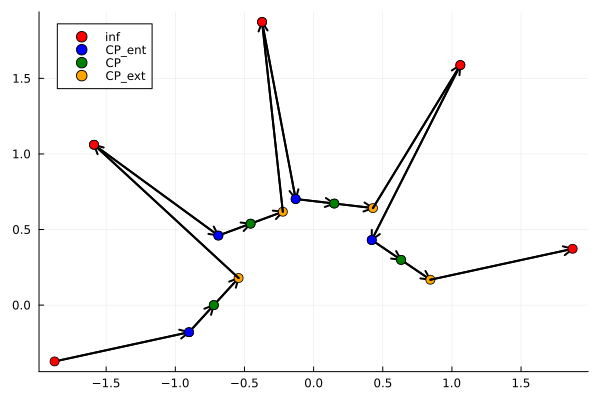

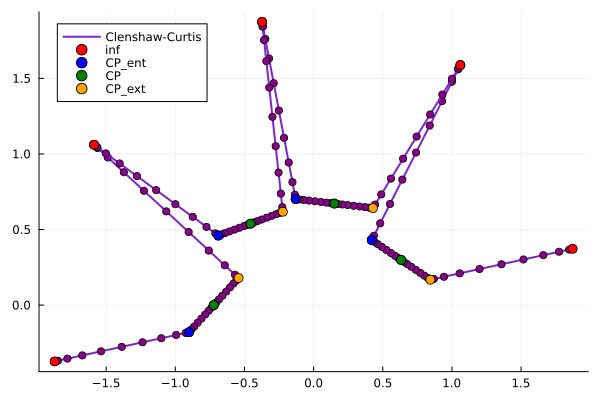

In [38]:
w = -[-2,-9,5,-1,-4,1,3];
xx = 2;
tt = 0.00001;
DD = FullPath(w, xx+eps(), tt);
plot_paths(DD.pp,DD.cc)
plot_D(DD)

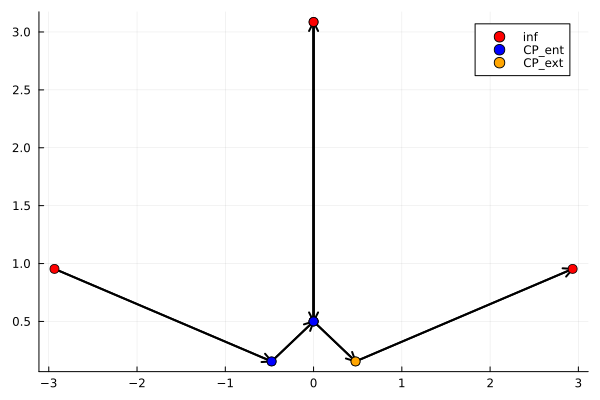

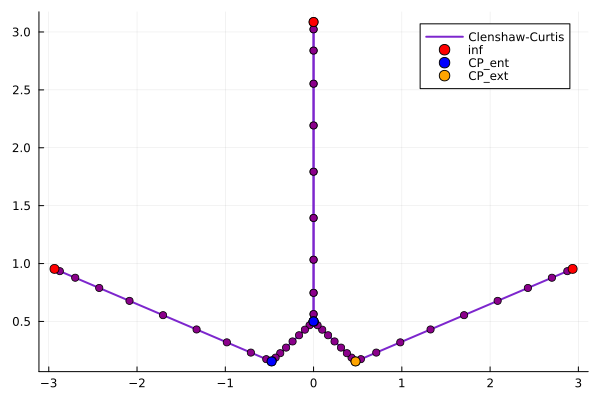

In [39]:
#w = -[-1/2 2 5];
w=  [0,0,0,-1];
xx = 0.0001;
tt = 0.00001;
DD = FullPath(w, xx+eps(), tt);
plot_paths(DD.pp,DD.cc)
plot_D(DD)

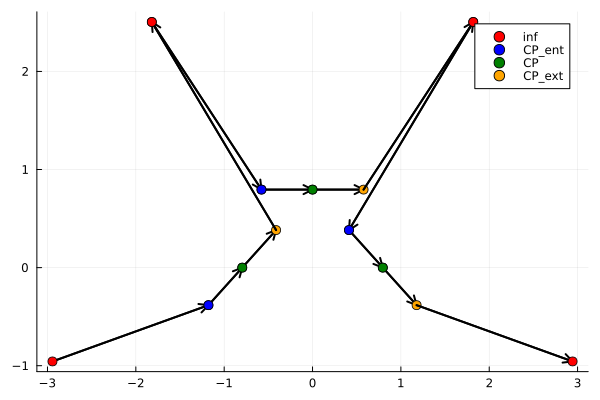

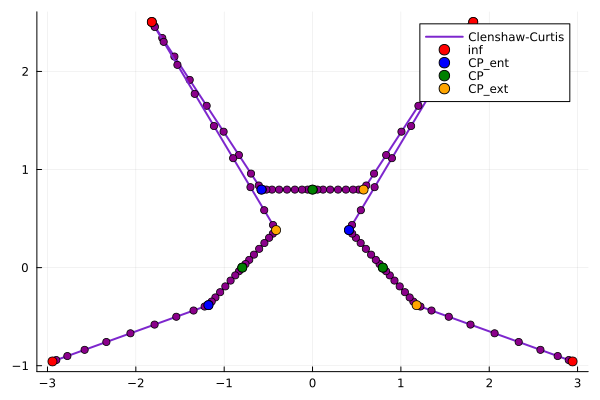

In [40]:
w = [0, 0, 0, 1];
xx = 2;
tt = 10^(-12);
DD =  FullPath(w, xx+eps(), tt);
plot_paths(DD.pp,DD.cc)
plot_D(DD)

In [49]:
function My_Integrate(int_f,Defor,N)
    res = 0im;
    for i1 = 1:length(Defor.tt)

        s = curv(Defor.path[i1],Defor.tt[i1][1],Defor.tt[i1][end],Defor.Dpath[i1],N)
        f = stand_int(int_f,s)

        if Defor.meth[i1] == "Legendre"

            x, w = gausslegendre(N);
           
        elseif Defor.meth[i1] == "Clenshaw-Curtis"

            if mod(N,2) != 0
               N -= 1 
            end
            
            n = 0:N/2;
            D = 2 * cos.(2* transpose(n) .* n * pi/N)/N;
            D[1,:] = D[1,:] .* 0.5;
            d = [1; 2 ./ (1 .- (2:2:N).^2)];
            w = D * d; w = [w;w[length(w)-1:-1:1]];
            x = cos.( (0:N) * π / N );
        end
        res += dot(w,f.(x))
    end
    return res
end

My_Integrate (generic function with 1 method)

In [50]:
function Integrand(w, xx, tt, m)
    DD = FullPath(w, xx, tt)
    integrand = z -> (1im * z)^m * P(w, xx+eps(), tt, z)
    return integrand, DD
end

Integrand (generic function with 1 method)

In [51]:
function SpecialFunction(w, xx, tt, m, N)
    n = length(w) + 1
    w = real(xx) >= 0. ? w : [w[i] * (-1)^(i + 1) for i in 1:length(w)];
    integrand, DD = Integrand(w, sign(real(xx)) * xx * tt^(-1/n), tt, m);

    extra_c = real(xx) < 0. ? (-1)^m : 1;
    vals = extra_c * My_Integrate(integrand, DD,N)
    #vals -=  (real(xx) < 0 && m < 0)? 2 * π * im * Residue(z -> (im * z)^m * P(w, xx * tt^(-1/n), tt, z), 0) : 0
    
    1 / (2 * π) * tt^(-(m + 1) / n) * vals
end

SpecialFunction (generic function with 1 method)

In [70]:
w = [0,0,0,-1]
N = 30;
x = 0
t = .00001
funt = N -> SpecialFunction(w, x, t, 1, N)
funt(N)

-8.300257696353219 + 3.533949646070575e-15im

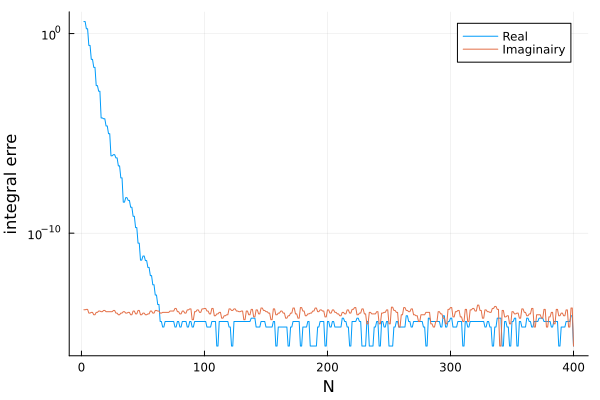

In [71]:
refs = funt(400)
plot(2:400,abs.(real.(funt.(collect(2:400)) .- refs)) .+ eps(), xlabel = "N", ylabel = "integral erre", label = "Real", yaxis =:log)
plot!(2:400,abs.(imag.(funt.(collect(2:400)) .- refs)) .+ eps(), label = "Imaginairy")

In [65]:
w = [1]
N = 30;
m = -1;
x = .1
t = .1
funt = N -> SpecialFunction(w, x, t, m, N)
SpecialFunction(w, x, t, m, N)

-0.43692377523021614 - 0.06540124395881514im

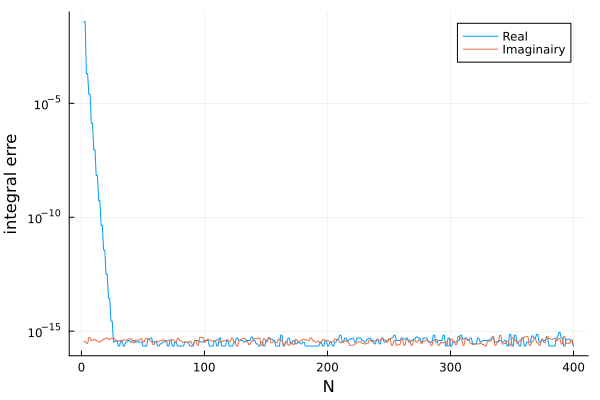

In [64]:
refs = funt(400)
plot(2:400,abs.(real.(funt.(collect(2:400)) .- refs)) .+ eps(), xlabel = "N", ylabel = "integral erre", label = "Real", yaxis =:log)
plot!(2:400,abs.(imag.(funt.(collect(2:400)) .- refs)) .+ eps(), label = "Imaginairy")

In [56]:
n = 50
w = zeros(n-1); w[end] = 1
N = 300;
m=-1
funt = (x,t) -> 1 + SpecialFunction(w, x, t, m, N)
funt(1,1)

0.7980387850691127 - 0.008351767473832527im